In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# visualization library
import seaborn as sns

In [106]:
df = pd.read_csv("df_Preprocessed.csv")
df=df.drop(['dteday'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cluster
0,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,low
1,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,low
2,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,low
3,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,low
4,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,low


In [86]:
from sklearn.model_selection import train_test_split

feature_cols = ['season','mnth','workingday','weathersit']
X = df.loc[:, feature_cols]
y = df.cluster

#Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Train size",X_train.shape[0])
print("Test size", len(X_test))

Train size 489
Test size 242


In [105]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier




def  My_Classifier (X_train, y_train, X_test, y_test):
    maxScore =0
    logreg = LogisticRegression()
    clf=RandomForestClassifier(n_estimators=100)
    nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)

    #fit
    logreg.fit(X_train, y_train)
    clf.fit(X_train,y_train)
    nn.fit(X_train, y_train)   

    #Score
    score=logreg.score(X_test,y_test)
    print('Logistic Regression SCORE: ', score)
    score=clf.score(X_test,y_test)
    print('Random Forest SCORE: ', score)
    score=nn.score(X_test,y_test)
    print('Neural Network: ', score)
    
    #Score for K-Neigh
    for n in range (1,100):
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(X_train, y_train) 
        if maxScore < neigh.score(X_test,y_test):
            n1 = n
            maxScore = neigh.score(X_test,y_test)

    print('K-Neighbors SCORE: ', maxScore, ' N= ', n1)
    
My_Classifier (X_train, y_train,X_test, y_test)

Logistic Regression SCORE:  0.6363636363636364
Random Forest SCORE:  0.7727272727272727
Neural Network:  0.7454545454545455
K-Neighbors SCORE:  0.7318181818181818  N=  2


# Feature selection

In [118]:
feature_cols = ['instant','season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_cols]
y = df.cluster



In [119]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 8 best features
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

         Specs         Score
0      instant  33491.883011
3         mnth    142.379352
2           yr    125.752042
1       season     73.559153
8         temp     20.697685
9        atemp     17.442359
7   weathersit     12.650286
4      holiday      4.042412
5      weekday      3.531337
11   windspeed      1.342996


[0.18886466 0.08259781 0.10211984 0.07552356 0.00804336 0.05150271
 0.02120626 0.05946502 0.15150316 0.13995784 0.05648405 0.06273173]


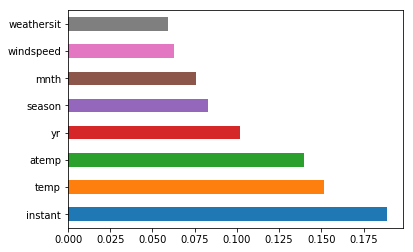

In [120]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

# Second try

In [121]:
import warnings; warnings.simplefilter('ignore')

features1=['mnth','yr','season','temp','atemp','hum']
X = df.loc[:, features1]
y = df.cluster

#Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("Train size",X_train.shape[0])
print("Test size", len(X_test))
My_Classifier(X_train, y_train,X_test, y_test)

Train size 511
Test size 220
Logistic Regression SCORE:  0.6363636363636364
Random Forest SCORE:  0.7545454545454545
Neural Network:  0.7454545454545455
K-Neighbors SCORE:  0.7318181818181818  N=  2


# Tentativo di predizione temporale

In [117]:
import warnings; warnings.simplefilter('ignore')

features1=['mnth','yr','season','temp','atemp','hum']

X = df.loc[:, features1]
mask_train = (df['instant'] < 550)
mask_test = (df['instant'] >= 550)

X_train=X.loc[mask_train]
y_train=df.loc[mask_train].cluster
X_test=X.loc[mask_test]
y_test=df.loc[mask_test].cluster


print("Train size",X_train.shape[0])
print("Test size", len(X_test))
My_Classifier(X_train, y_train,X_test, y_test)

Train size 549
Test size 182
Logistic Regression SCORE:  0.46153846153846156
Random Forest SCORE:  0.4340659340659341
Neural Network:  0.1813186813186813
K-Neighbors SCORE:  0.17582417582417584  N=  5


# Tuning